In [ ]:
import numpy as np
import pandas as pd

# Importing necessary libraries for this notebook.
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime
import time
from decimal import Decimal

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, f1_score

from keras.models import Sequential, load_model
from keras.layers import Input, Dense, Activation, Dropout, BatchNormalization, LeakyReLU, LSTM
from keras.regularizers import l2, l1
from keras.metrics import BinaryAccuracy
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint

import tensorflow as tf

import os
from google.colab import files

# Compress the directory into a zip file
import shutil
import warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*You are saving your model as an HDF5 file*.")

# Functions

## Neural Network Functions

In [ ]:
def split_data(X, y):
  X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

  # Print the sizes of each set
  print(f"Training set size: {X_train.shape[0]}")
  print(f"Validation set size: {X_val.shape[0]}")
  print(f"Test set size: {X_test.shape[0]}")

  return X_train, X_val, X_test, y_train, y_val, y_test

In [ ]:
def scale_data(scaler, X_train, X_val, X_test):
  columns = X_train.columns
  scaler.fit(np.array(X_train[columns]))

  X_train[columns] = scaler.transform(np.array(X_train[columns]))
  X_val[columns] = scaler.transform(np.array(X_val[columns]))
  X_test[columns] = scaler.transform(np.array(X_test[columns]))

  return X_train, X_val, X_test

In [ ]:
def create_model(input_dim, kernel_regularizer=None, dropout=False):
    model = Sequential()

    # Input layer
    model.add(Input(shape=(input_dim,)))

    # First hidden layer
    model.add(Dense(64, kernel_regularizer=kernel_regularizer))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    if dropout:
        model.add(Dropout(0.3))

    # Second hidden layer
    model.add(Dense(32, kernel_regularizer=kernel_regularizer))
    model.add(BatchNormalization())
    model.add(LeakyReLU(negative_slope=0.1))
    if dropout:
        model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
def run_metrics(model, X_test, y_test, threshold_range=np.arange(0.1, 0.9, 0.1), cv_folds=5):
    """
    Run metrics evaluation for a given model and test dataset.

    Args:
    - model: Trained model.
    - X_test: Test feature data.
    - y_test: Test labels.
    - threshold_range: Array of thresholds to evaluate.
    - cv_folds: Number of cross-validation folds.

    Returns:
    - test_accuracy: Accuracy on the test data.
    - best_f1: Best F1 score obtained.
    - best_threshold: Threshold that yields the best F1 score.
    """
    def calculate_f1_threshold(model, X, y, threshold):
        y_pred_prob = model.predict(X, verbose=0)
        y_pred = [1 if i >= threshold else 0 for i in y_pred_prob]
        return f1_score(y, y_pred)

    # Cross-validation to find the best threshold
    skf = StratifiedKFold(n_splits=cv_folds)
    best_f1 = 0
    best_threshold = 0

    for threshold in threshold_range:
        f1_scores = []

        for train_index, val_index in skf.split(X_test, y_test):
            X_train, X_val = X_test.iloc[train_index], X_test.iloc[val_index]
            y_train, y_val = y_test.iloc[train_index], y_test.iloc[val_index]

            f1 = calculate_f1_threshold(model, X_val, y_val, threshold)
            f1_scores.append(f1)

        avg_f1 = np.mean(f1_scores)

        if avg_f1 > best_f1:
            best_f1 = avg_f1
            best_threshold = np.round(threshold, 2)

    best_threshold = np.round(best_threshold, 2)
    print(f"\nBest Threshold: {best_threshold}")

    # Calculate test accuracy and F1 score using the best threshold
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = [1 if i >= best_threshold else 0 for i in y_pred_prob]
    test_accuracy = round((model.evaluate(X_test, y_test, verbose=0)[1] * 100), 2)
    print(f"\nAccuracy on test data: {test_accuracy}%")

    f1 = round(f1_score(y_test, y_pred) * 100, 2)
    print(f"\nF1 Score on test data with best threshold: {f1}")

    # Plot confusion matrix
    plt.title("Confusion Matrix for Test Data", fontdict={'fontsize': 18})
    ax = sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues", xticklabels=["0", "1"], yticklabels=["0", "1"])
    ax.set_xlabel('Predicted Labels', fontsize=14)
    ax.set_ylabel('Actual Labels', fontsize=14)
    plt.show()

    return test_accuracy, f1, best_threshold

In [ ]:
def split_and_scale(X, y, features_cols, target_col, test_data_provided, df_test):
    # Split data
    print("Splitting data...")
    if test_data_provided:
        X_test = df_test[features_cols].copy()
        y_test = df_test[target_col].copy()
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42)
        print(f"Training set size: {X_train.shape[0]}")
        print(f"Validation set size: {X_val.shape[0]}")
        print(f"Test set size: {X_test.shape[0]}")
    else:
        X_train, X_val, X_test, y_train, y_val, y_test = split_data(X, y)

    # Scale data
    print("\nScaling data...")
    scaler = MinMaxScaler()
    X_train_scaled, X_val_scaled, X_test_scaled = scale_data(scaler, X_train, X_val, X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test, scaler

## Deployment Functions

In [ ]:
def generate_constants_file(scaler, save_dir, feature_columns, threshold):

  max_defines = [f"#define MAX_{col.upper()}" for col in feature_columns]
  min_defines = [f"#define MIN_{col.upper()}" for col in feature_columns]

  data_max = scaler.data_max_
  data_min = [float(Decimal(val)) for val in scaler.data_min_]
  filename = os.path.join(save_dir, 'AI_constants.h')
  with open(filename, "w") as output:
    output.write("#ifndef AI_CONSTANTS_H\n")
    output.write("#define AI_CONSTANTS_H")
    output.write("\n\n")
    output.write("// max of features\n")

    for i, define in enumerate(max_defines):
      output.write(define + " " +str(float(Decimal(data_max[i]))) + "\n")

    output.write("\n\n")
    output.write("// min of features\n")

    for i, define in enumerate(min_defines):
      output.write(define + " " + str(float(Decimal(data_min[i]))) + "\n")

    output.write("\n\n")
    output.write("// decision boundary\n")
    output.write("#define DECISION_BOUNDARY " + str(Decimal(threshold)) + "\n")

    output.write("\n#endif // AI_CONSTANTS_H")

In [ ]:
def extract_data(X_test, y_test, X_train, y_train, test_accuracy, f1, threshold, scaler, features_cols, version_name, save_dir):

    # Extract train and test data
    X_test_csv_path = os.path.join(save_dir, "test_" + version_name + '_input.csv')
    X_test.to_csv(X_test_csv_path, index=False, header=False)

    y_test_csv_path = os.path.join(save_dir, "test_" + version_name + '_target.csv')
    y_test.to_csv(y_test_csv_path, index=False, header=False)

    X_train_csv_path = os.path.join(save_dir, "train_" + version_name +'_input.csv')
    X_train.to_csv(X_train_csv_path, index=False, header=False)

    y_train_csv_path = os.path.join(save_dir, "train_" + version_name + '_target.csv')
    y_train.to_csv(y_train_csv_path, index=False, header=False)

    # Extract metrics
    metrics_path = os.path.join(save_dir,'metrics.txt')
    with open(metrics_path, "w") as output:
      output.write(f"\nAccuracy on test data: {test_accuracy}%")
      output.write(f"\nF1 Score on test data: {f1}")

    # Extract scaler
    generate_constants_file(scaler, save_dir, features_cols, threshold)

    # Zip the directory and Download the zip file
    print("\nZipping and downloading files...\n")
    shutil.make_archive(save_dir, 'zip', save_dir)
    files.download(version_name + '.zip')

In [ ]:
def delete_save_dir(folder_path):
    # Check if folder exists
    if os.path.exists(folder_path):
        # Delete all files in the folder
        for filename in os.listdir(folder_path):
            file_path = os.path.join(folder_path, filename)
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        # Remove the folder
        shutil.rmtree(folder_path)
        print(f"All files in {folder_path} have been deleted and the folder has been removed successfully.\n")
    else:
        print(f"{folder_path} does not exist.\n")

## LSTM Model Functions

In [ ]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
def create_lstm_sequences(data, time_steps):
    """
    Create sequences from the data.

    Parameters:
    - data: DataFrame or 2D array with shape (n_samples, n_features)
    - time_steps: Number of time steps per sequence
    - overlap: Number of overlapping time steps

    Returns:
    - sequences: 3D array of shape (n_sequences, time_steps, n_features)
    """
    sequences = []
    num_samples, num_features = data.shape

    step = 1
    for i in range(0, num_samples - time_steps + 1, step):
        end = i + time_steps
        sequences.append(data[i:end])

    return np.array(sequences)

In [ ]:
def scale_data_lstm(scaler, X_train, X_val, X_test):
    # Flatten the sequences for scaling
    X_train_flat = X_train.reshape(-1, X_train.shape[-1])
    X_val_flat = X_val.reshape(-1, X_val.shape[-1])
    X_test_flat = X_test.reshape(-1, X_test.shape[-1])

    # Fit the scaler on the training data and transform all sets
    X_train_scaled = scaler.fit_transform(X_train_flat)
    X_val_scaled = scaler.transform(X_val_flat)
    X_test_scaled = scaler.transform(X_test_flat)

    # Reshape back to the original shape
    X_train_scaled = X_train_scaled.reshape(X_train.shape)
    X_val_scaled = X_val_scaled.reshape(X_val.shape)
    X_test_scaled = X_test_scaled.reshape(X_test.shape)

    return X_train_scaled, X_val_scaled, X_test_scaled

In [ ]:
def split_and_scale_chronologically(X, y, features_cols, target_col, time_steps = 15):

    overlap = time_steps - 1
    # Split data
    print("Splitting data...")
    # Determine split indices
    train_size = int(len(X) * 0.6)
    val_size = int(len(X) * 0.2)
    test_size = len(X) - train_size - val_size

    # Split the data chronologically
    X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
    y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
    print(f"Training set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")
    print(f"Test set size: {X_test.shape[0]}")

    # Create sequences for X and y
    X_train_sequences = create_lstm_sequences(X_train, time_steps)
    X_val_sequences = create_lstm_sequences(X_val, time_steps)
    X_test_sequences = create_lstm_sequences(X_test, time_steps)

    # Create corresponding target sequences (use the last value in each sequence as the target)
    y_train_sequences = y_train[time_steps-1::time_steps-overlap]
    y_val_sequences = y_val[time_steps-1::time_steps-overlap]
    y_test_sequences = y_test[time_steps-1::time_steps-overlap]

    # Check shapes
    print(f"Shape of X_train: {X_train_sequences.shape}")  # Should be (num_sequences, time_steps, num_features)
    print(f"Shape of y_train: {y_train_sequences.shape}")  # Should be (num_sequences, time_steps, 1)

    # Scale data
    print("\nScaling data...")
    scaler = MinMaxScaler()
    X_train_scaled, X_val_scaled, X_test_scaled = scale_data_lstm(scaler, X_train_sequences, X_val_sequences, X_test_sequences)


    return X_train_scaled, X_val_scaled, X_test_scaled, y_train_sequences, y_val_sequences, y_test_sequences, scaler

## Train and Evaluate Function

In [ ]:
def train_and_evaluate_model(df, target_col, features_cols, kernel_regularizer, dropout,
                            batch_size, test_data_provided = False, df_test = None,
                            data_set_name = "data_set", feature_set_name = "regular",
                            lstm_model = False, deploy = False, time_steps = 15):

    # Split and scale data
    if lstm_model:
      X = df[features_cols].values
      y = df[target_col].values
      X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale_chronologically(X, y, features_cols, target_col,  time_steps = time_steps)

      input_shape = (X_train.shape[1], X_train.shape[2])
      model = create_lstm_model(input_shape)
    else:
      X = df[features_cols]
      y = df[target_col]
      X_train, X_val, X_test, y_train, y_val, y_test, scaler = split_and_scale(X, y, features_cols, target_col, test_data_provided, df_test)

      # Create model
      input_dim = X_train.shape[-1]
      print(f"\nInput dimension: {input_dim}")

      model = create_model(input_dim, kernel_regularizer=kernel_regularizer, dropout=dropout)

    # Create a new directory
    version_name = data_set_name + "_" + feature_set_name
    save_dir = '/content/' + version_name
    if not os.path.exists(save_dir):
      os.makedirs(save_dir, exist_ok=True)
    best_model_name_keras = version_name + '.keras'
    best_model_name_h5 =  version_name + '.h5'
    model_checkpoint_path = os.path.join(save_dir, best_model_name_keras)

    # Early stopping and checkpoint
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model_checkpoint = ModelCheckpoint(model_checkpoint_path, save_best_only=True, monitor='val_loss')

    # Train model
    if deploy:
      epochs = 200
    else:
      epochs = 100

    print(f"\nTraining model with batch_size = {batch_size} and {epochs} epochs...")
    print(f"\nSaving best model to {model_checkpoint_path}\n")
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val),
              callbacks=[early_stopping, model_checkpoint], verbose=0)

    # Load the best model based on the saved weights
    model = tf.keras.models.load_model(model_checkpoint_path)
    # Check its architecture
    model.summary()

    #Save the model into h5 format
    model_path = os.path.join(save_dir, best_model_name_h5)
    model.save(model_path)

    #model = load_model(model_path)
    print(f"\nBest model loaded from {model_path}")

    # Evaluate model
    test_accuracy, f1, threshold = run_metrics(model, X_test, y_test, threshold_range=np.arange(0.1, 0.9, 0.1), cv_folds=5)

    # Extract the train and test dataframes scaled
    if deploy:
      extract_data(X_test, y_test, X_train, y_train, test_accuracy, f1, threshold, scaler, features_cols, version_name, save_dir)
    else:
      delete_save_dir(save_dir)

    return model, scaler, test_accuracy, f1, threshold

# Classes

In [ ]:
class Training_info:
    def __init__(self, dataset_name, feature_set_name, model=None, scaler=None, test_accuracy=None, f1=None, threshold=None):
        self.dataset_name = dataset_name
        self.feature_set_name = feature_set_name
        self.model = model
        self.scaler = scaler
        self.test_accuracy = test_accuracy
        self.f1 = f1
        self.threshold = threshold

    def set_model(self, model):
        self.model = model

    def set_scaler(self, scaler):
        self.scaler = scaler

    def set_test_accuracy(self, test_accuracy):
        self.test_accuracy = test_accuracy

    def set_f1(self, f1):
        self.f1 = f1

    def set_threshold(self, threshold):
        self.threshold = threshold

    def get_model(self):
        return self.model

    def get_scaler(self):
        return self.scaler

    def get_test_accuracy(self):
        return self.test_accuracy

    def get_f1(self):
        return self.f1

    def get_threshold(self):
        return self.threshold

    def display_info(self):
        print(f"Dataset: {self.dataset_name}")
        print(f"Feature Set: {self.feature_set_name}")
        print(f"Test Accuracy: {self.test_accuracy}%")
        print(f"F1 Score: {self.f1}")
        print(f"Threshold: {self.threshold}")


# Constants

In [ ]:
# Best results from hyperparameter tuning of best_model_selection notebook
best_kernel_regularizer = None
best_dropout = False
best_batch_size = 32

In [ ]:
# Feature Selection
target_column = "occupancy"

feature_columns = ['temperature','humidity','co2_concentration','average_co2_last_hour','average_temperature_last_hour',
           'average_humidity_last_hour','current_value_minus_average_last_hour_co2','current_value_minus_average_last_hour_temperature',
           'current_value_minus_average_last_hour_humidity','current_value_minus_last_15_min_co2','current_value_minus_last_15_min_temperature',
           'current_value_minus_last_15_min_humidity','room_number','floor_area']

basic_feature_columns = ['co2_concentration','temperature','humidity','average_co2_last_hour','average_temperature_last_hour','average_humidity_last_hour']

acceleration_columns = ['temperature','humidity','co2_concentration','average_co2_last_hour','average_temperature_last_hour',
           'average_humidity_last_hour','current_value_minus_average_last_hour_co2','current_value_minus_average_last_hour_temperature',
           'current_value_minus_average_last_hour_humidity','current_value_minus_last_15_min_co2','current_value_minus_last_15_min_temperature',
           'current_value_minus_last_15_min_humidity','acceleration_co2','acceleration_temperature','acceleration_humidity','room_number','floor_area']

**Feature Notations**

* regular = instant values, averages, variations, room info, no time features
* acceleration = regular + CO2, temperature, and humidity acceleration
* basic = instant values and averages

# Feature and Dataset Engineering

## Train on Tera

In [ ]:
tera_df = pd.read_csv('/content/sample_data/teraterm.csv')

Splitting data...
Training set size: 1160
Validation set size: 387
Test set size: 387

Scaling data...

Input dimension: 14

Training model with batch_size = 32 and 100 epochs...

Saving best model to /content/tera_regular/tera_regular.keras



Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_70 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_44               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_44 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_71 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_45               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_45 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_72 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,989 (39.02 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 6,532 (25.52 KB)


Best model loaded from /content/tera_regular/tera_regular.h5

Best Threshold: 0.6

Accuracy on test data: 95.87%

F1 Score on test data with best threshold: 95.3


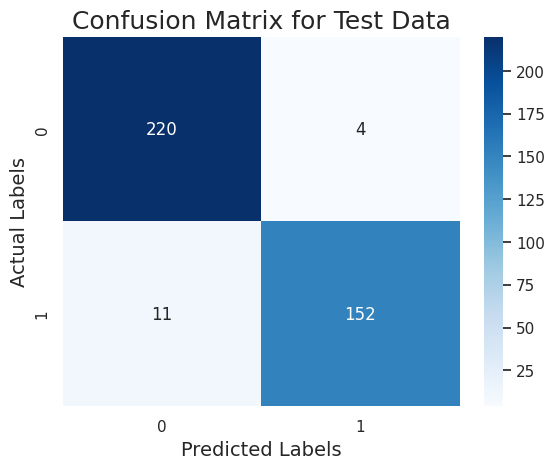

All files in /content/tera_regular have been deleted and the folder has been removed successfully.

Dataset: Tera Dataset
Feature Set: regular
Test Accuracy: 95.87%
F1 Score: 95.3
Threshold: 0.6


In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(tera_df, target_column, feature_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "tera", feature_set_name = "regular",
                                                                        lstm_model = False, deploy = False, time_steps = 15)
# Create an instance of TrainingInfo
training_info1 = Training_info(
    dataset_name="Tera Dataset",
    feature_set_name="regular",
    model=model,
    scaler=scaler,
    test_accuracy=test_accuracy,
    f1=f1,
    threshold=threshold
)

# Display the training information
training_info1.display_info()


Splitting data...
Training set size: 1160
Validation set size: 387
Test set size: 387

Scaling data...

Input dimension: 17

Training model with batch_size = 32 and 100 epochs...

Saving best model to /content/tera_acceleration/tera_acceleration.keras



Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_73 (Dense)                     │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_46               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_46 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_74 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_47               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_47 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_75 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,565 (41.27 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 6,916 (27.02 KB)


Best model loaded from /content/tera_acceleration/tera_acceleration.h5

Best Threshold: 0.5

Accuracy on test data: 95.61%

F1 Score on test data with best threshold: 94.83


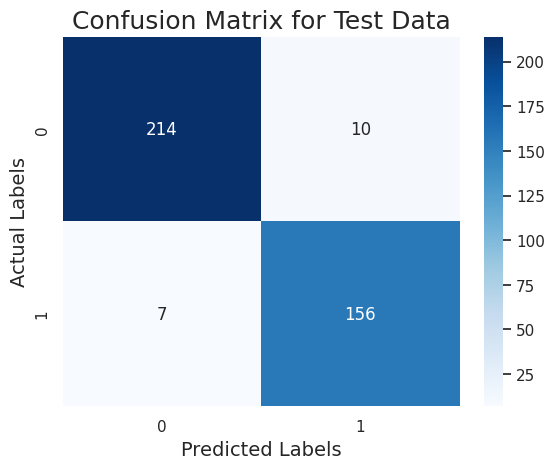

All files in /content/tera_acceleration have been deleted and the folder has been removed successfully.

Dataset: Tera Dataset
Feature Set: acceleration
Test Accuracy: 95.61%
F1 Score: 94.83
Threshold: 0.5


In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(tera_df, target_column, acceleration_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "tera", feature_set_name = "acceleration",
                                                                        lstm_model = False, deploy = False)
# Create an instance of TrainingInfo
training_info2 = Training_info(
    dataset_name="Tera Dataset",
    feature_set_name="acceleration",
    model=model,
    scaler=scaler,
    test_accuracy=test_accuracy,
    f1=f1,
    threshold=threshold
)

# Display the training information
training_info2.display_info()


## Train on Tera + room_occupancy

In [ ]:
df_room_occ = pd.read_csv('/content/sample_data/room_occupancy.csv')

df_merged = pd.concat([df_room_occ, tera_df], ignore_index=True, sort=False)

Splitting data...
Training set size: 7620
Validation set size: 2541
Test set size: 2541

Scaling data...

Input dimension: 17

Training model with batch_size = 32 and 100 epochs...

Saving best model to /content/tera+room_occ_acceleration/tera+room_occ_acceleration.keras



Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_76 (Dense)                     │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_48 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_77 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_49 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_78 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,565 (41.27 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 6,916 (27.02 KB)


Best model loaded from /content/tera+room_occ_acceleration/tera+room_occ_acceleration.h5

Best Threshold: 0.4

Accuracy on test data: 85.91%

F1 Score on test data with best threshold: 74.53


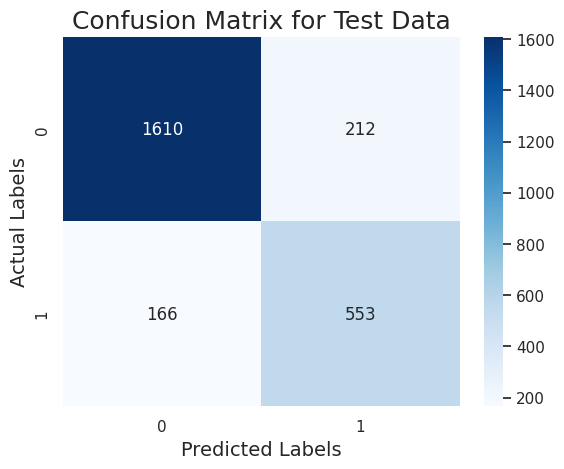

All files in /content/tera+room_occ_acceleration have been deleted and the folder has been removed successfully.

Dataset: tera + room_occupancy Datasets
Feature Set: acceleration
Test Accuracy: 85.91%
F1 Score: 74.53
Threshold: 0.4


In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(df_merged, target_column, acceleration_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "tera+room_occ", feature_set_name = "acceleration",
                                                                        lstm_model = False, deploy = False)
# Create an instance of TrainingInfo
training_info3 = Training_info(
    dataset_name="tera + room_occupancy Datasets",
    feature_set_name="acceleration",
    model=model,
    scaler=scaler,
    test_accuracy=test_accuracy,
    f1=f1,
    threshold=threshold
)

# Display the training information
training_info3.display_info()


## Train on augmented tera

In [ ]:
augmented_tera_df = pd.read_csv('/content/sample_data/augmented_tera_x4.csv')
test_tera_df = pd.read_csv('/content/sample_data/test_tera.csv')

Splitting data...
Training set size: 10809
Validation set size: 3603
Test set size: 3604

Scaling data...

Input dimension: 14

Training model with batch_size = 32 and 100 epochs...

Saving best model to /content/augmented_tera_regular/augmented_tera_regular.keras



Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_79 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_50 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_80 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_51 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_81 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,989 (39.02 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 6,532 (25.52 KB)


Best model loaded from /content/augmented_tera_regular/augmented_tera_regular.h5

Best Threshold: 0.4

Accuracy on test data: 88.26%

F1 Score on test data with best threshold: 86.08


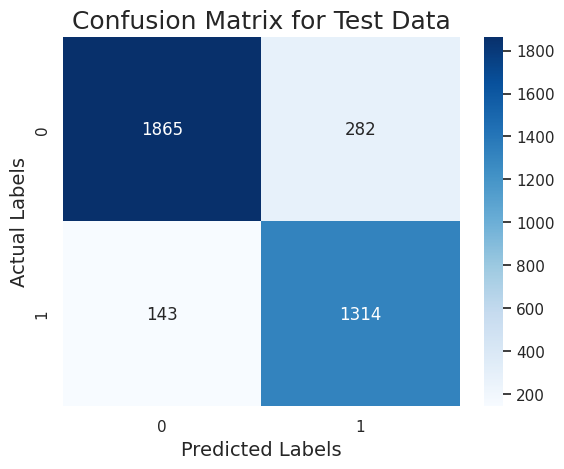

All files in /content/augmented_tera_regular have been deleted and the folder has been removed successfully.

Dataset: Augmented tera
Feature Set: regular
Test Accuracy: 88.26%
F1 Score: 86.08
Threshold: 0.4


In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(augmented_tera_df, target_column, feature_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "augmented_tera", feature_set_name = "regular",
                                                                        lstm_model = False, deploy = False)
# Create an instance of TrainingInfo
training_info4 = Training_info(
    dataset_name="Augmented tera",
    feature_set_name="regular",
    model=model,
    scaler=scaler,
    test_accuracy=test_accuracy,
    f1=f1,
    threshold=threshold
)

# Display the training information
training_info4.display_info()


Splitting data...
Training set size: 10809
Validation set size: 3603
Test set size: 3604

Scaling data...

Input dimension: 6

Training model with batch_size = 32 and 100 epochs...

Saving best model to /content/augmented_tera_basic/augmented_tera_basic.keras



Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_88 (Dense)                     │ (None, 64)                  │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_56               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_56 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_89 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_57               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_57 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_90 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,453 (33.02 KB)

 Trainable params: 2,753 (10.75 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 5,508 (21.52 KB)


Best model loaded from /content/augmented_tera_basic/augmented_tera_basic.h5

Best Threshold: 0.3

Accuracy on test data: 86.9%

F1 Score on test data with best threshold: 84.0


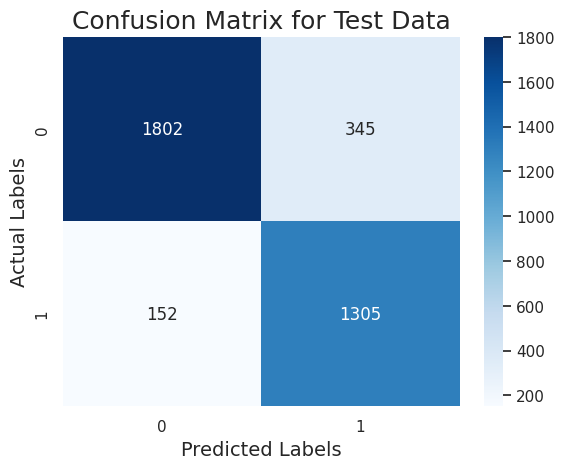

All files in /content/augmented_tera_basic have been deleted and the folder has been removed successfully.

Dataset: Augmented tera
Feature Set: basic
Test Accuracy: 86.9%
F1 Score: 84.0
Threshold: 0.3


In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(augmented_tera_df, target_column, basic_feature_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "augmented_tera", feature_set_name = "basic",
                                                                        lstm_model = False, deploy = False)
# Create an instance of TrainingInfo
training_info5 = Training_info(
    dataset_name="Augmented tera",
    feature_set_name="basic",
    model=model,
    scaler=scaler,
    test_accuracy=test_accuracy,
    f1=f1,
    threshold=threshold
)

# Display the training information
training_info5.display_info()


Splitting data...
Training set size: 10809
Validation set size: 3603
Test set size: 3604

Scaling data...

Input dimension: 17

Training model with batch_size = 32 and 100 epochs...

Saving best model to /content/augmented_tera_acceleration/augmented_tera_acceleration.keras



Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_85 (Dense)                     │ (None, 64)                  │           1,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_54               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_54 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_86 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_55               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_55 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_87 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,565 (41.27 KB)

 Trainable params: 3,457 (13.50 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 6,916 (27.02 KB)


Best model loaded from /content/augmented_tera_acceleration/augmented_tera_acceleration.h5

Best Threshold: 0.4

Accuracy on test data: 85.82%

F1 Score on test data with best threshold: 82.9


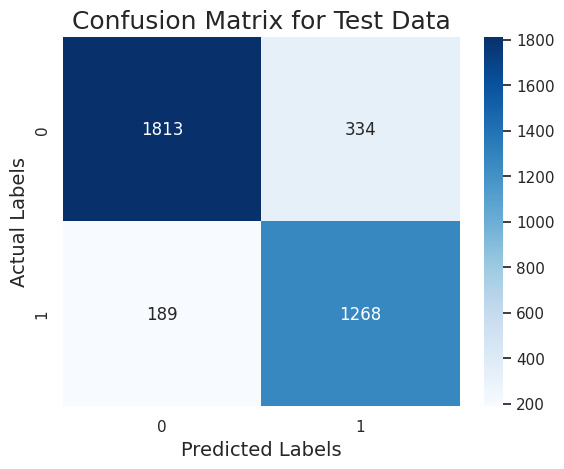

All files in /content/augmented_tera_acceleration have been deleted and the folder has been removed successfully.

Dataset: Augmented tera
Feature Set: acceleration
Test Accuracy: 85.82%
F1 Score: 82.9
Threshold: 0.4


In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(augmented_tera_df, target_column, acceleration_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "augmented_tera", feature_set_name = "acceleration",
                                                                        lstm_model = False, deploy = False)
# Create an instance of TrainingInfo
training_info6 = Training_info(
    dataset_name="Augmented tera",
    feature_set_name="acceleration",
    model=model,
    scaler=scaler,
    test_accuracy=test_accuracy,
    f1=f1,
    threshold=threshold
)

# Display the training information
training_info6.display_info()


# Results

In [ ]:
training_infos = {
    "tera regular": training_info1,
    "tera acceleration": training_info2,
    "tera+room_occ acceleration":training_info3,
    "augmented_tera regular":training_info4,
    "augmented_tera basic":training_info5,
    "augmented_tera acceleration":training_info6
}


In [ ]:
print(training_infos.keys())
print(f"test_accuracy: {[training_infos[key].test_accuracy for key in training_infos.keys()]}")
print(f"f1:            {[training_infos[key].f1 for key in training_infos.keys()]}")

dict_keys(['tera regular', 'tera acceleration', 'tera+room_occ acceleration', 'augmented_tera regular', 'augmented_tera basic', 'augmented_tera acceleration'])
test_accuracy: [95.87, 95.61, 85.91, 88.26, 86.9, 85.82]
f1:            [95.3, 94.83, 74.53, 86.08, 84.0, 82.9]


Even though the best score belongs to tera dataset we will not implement that trained model because it will not generalize well since it was trained on a small dataset.

==> We will deploy the augmented tera data set with regular features

# Deploy

Splitting data...
Training set size: 10809
Validation set size: 3603
Test set size: 3604

Scaling data...

Input dimension: 14

Training model with batch_size = 32 and 200 epochs...

Saving best model to /content/augmented_tera_regular/augmented_tera_regular.keras



Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_91 (Dense)                     │ (None, 64)                  │             960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_58               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_58 (LeakyReLU)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_92 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_59               │ (None, 32)                  │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_59 (LeakyReLU)           │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_93 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,989 (39.02 KB)

 Trainable params: 3,265 (12.75 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 6,532 (25.52 KB)


Best model loaded from /content/augmented_tera_regular/augmented_tera_regular.h5

Best Threshold: 0.3

Accuracy on test data: 86.99%

F1 Score on test data with best threshold: 83.71


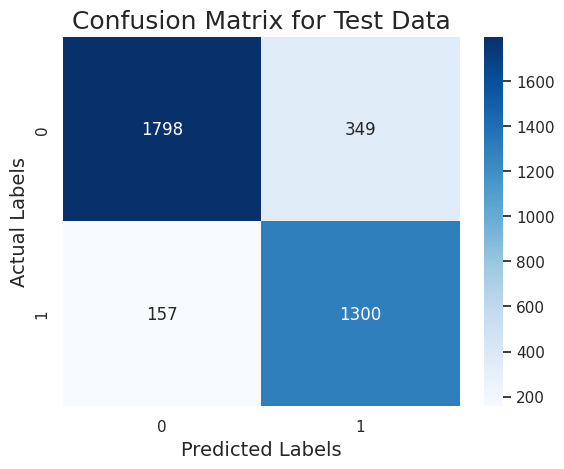


Zipping and downloading files...



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model, scaler, test_accuracy, f1, threshold = train_and_evaluate_model(augmented_tera_df, target_column, feature_columns, best_kernel_regularizer, best_dropout, best_batch_size,
                                                                        test_data_provided = False, df_test = None, data_set_name = "augmented_tera", feature_set_name = "regular",
                                                                        lstm_model = False, deploy = True)